<a href="https://colab.research.google.com/github/derek-byte/Melanoma_Deep_Learning/blob/main/MELANOMA_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
train_dir='/content/drive/MyDrive/Melanoma_Dataset/train'
labels = ['Melanoma', 'NotMelanoma']
print ("class :", labels[0], ",", labels[1]) 

class : Melanoma , NotMelanoma


In [ ]:
handle_base = "mobilenet_v2"
FV_SIZE = 1280
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16 

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 7290 images belonging to 2 classes.
Found 3123 images belonging to 2 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
___________________

In [ ]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=15
history = model.fit(
        train_generator,
        # steps_per_epoch = train_generator.samples//train_generator.batch_size,
        steps_per_epoch = 10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Checking Performance

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

NameError: ignored

Test At Random

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img
def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)
for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    print("class: %s, Confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

NameError: ignored

Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
report = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(report)

evaluates = model.evaluate(validation_generator)
print(evaluates)

Classification Report
              precision    recall  f1-score   support

    Melanoma       0.97      0.99      0.98      1521
 NotMelanoma       0.99      0.97      0.98      1602

    accuracy                           0.98      3123
   macro avg       0.98      0.98      0.98      3123
weighted avg       0.98      0.98      0.98      3123

196/196 [==============================] - 94s 477ms/step - loss: 0.0684 - accuracy: 0.9808
[0.06840399652719498, 0.9807876944541931]


Confusion Matrix


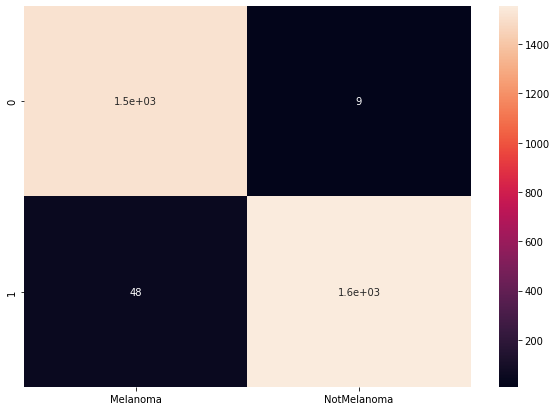

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
data_frame = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(data_frame, annot=True)

Export as Saved Model and Convert to TFLite

In [ ]:
import time
t = time.time()
export_path = "/content/drive/MyDrive/Melanoma_Models{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

NameError: ignored

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
path = "/content/drive/MyDrive/Melanoma_Models_Good_Copy"
reloaded = tf.keras.models.load_model(path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {labels[class_idx]: probabilities[class_idx]}

SOURCE: class: NotMelanoma, file: NotMelanoma/ISIC_0026534.jpg
PREDICTED: class: NotMelanoma, confidence: 0.997649


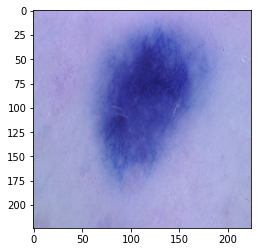

<Figure size 432x288 with 0 Axes>

SOURCE: class: Melanoma, file: Melanoma/AUG_0_2253.jpeg
PREDICTED: class: Melanoma, confidence: 0.893216


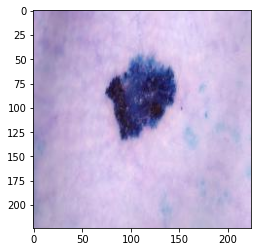

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# # convert the model to TFLite
# !mkdir "tflite_models"
# TFLITE_MODEL = "tflite_models/model.tflite"
# # Get the concrete function from the Keras model.
# run_model = tf.function(lambda x : reloaded(x))
# # Save the concrete function.
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
# )
# # Convert the model to standard TensorFlow Lite model
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# converted_tflite_model = converter.convert()
# open(TFLITE_MODEL, "wb").write(converted_tflite_model)

Streamlit

In [8]:
!ngrok authtoken 26myWhdKL3FJvSiQfVOLduesolf_3iGZpQGynAH14orGSyv9z

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pip install streamlit

In [ ]:
!pip install pyngrok

In [70]:
%%writefile app.py

import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobile 
import tensorflow_hub as hub
import matplotlib.pylab as plt

st.title("Melanoma Detection")
path = "/content/drive/MyDrive/Melanoma_Models_Good_Copy"
reloaded = tf.keras.models.load_model(path, custom_objects={'KerasLayer':hub.KerasLayer})
uploaded_file = st.file_uploader("Choose a image file", type=["png", "jpeg", "jpg", "svg"])

labels = ['Melanoma', 'NotMelanoma']

if uploaded_file is not None:
  # Convert the file to an opencv image
  file_bytes = np.asarray(bytearray(uploaded_file.read()),dtype=np.uint8)
  opencv_image = cv2.imdecode(file_bytes, 1)
  opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
  resized = cv2.resize(opencv_image, (224,224))

  def upload(filename):
      # img = cv2.imread(os.path.join(train_dir, filename))
      img = cv2.imread(opencv_image)
      img = cv2.resize(img, (224, 224) )
      img = img /255
      return img

  # Now confirm that we can reload it, and it still gives the same results
  def predict_reload(image):
      probabilities = reloaded.predict(np.asarray([img]))[0]
      class_idx = np.argmax(probabilities)
      return {labels[class_idx]: probabilities[class_idx]}

  # img = upload(opencv_image)
  img = resized
  prediction = predict_reload(img)
  st.write("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
  # Display image 
  st.image(opencv_image, channels="RGB")

# import streamlit as st
# import cv2
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image 
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobile 
# import tensorflow_hub as hub
# import matplotlib.pylab as plt
# import os

# st.title("Melanoma Detection")
# path = "/content/drive/MyDrive/Melanoma_Models_Good_Copy"
# reloaded = tf.keras.models.load_model(path, custom_objects={'KerasLayer':hub.KerasLayer})
# uploaded_file = st.file_uploader("Choose a image file", type=["png", "jpeg", "jpg", "svg"])

# labels = ['Melanoma', 'NotMelanoma']

# if uploaded_file is not None:
#   # Convert the file to an opencv image
#   file_bytes = np.asarray(bytearray(uploaded_file.read()),dtype=np.uint8)
#   opencv_image = cv2.imdecode(file_bytes, 1)
#   opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
#   resized = cv2.resize(opencv_image, (224,224))

#   export_path = "/content/drive/MyDrive/Melanoma_Images"
#   cv2.imwrite(export_path+str(uploaded_file), opencv_image)

#   train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         rescale = 1./255,
#         rotation_range=40,
#         horizontal_flip=True,
#         width_shift_range=0.2, 
#         height_shift_range=0.2,
#         shear_range=0.2, 
#         zoom_range=0.2,
#         fill_mode='nearest',
#         validation_split=0.3)
    
#   validation_generator = train_datagen.flow_from_directory(
#         '/content/drive/MyDrive/Melanoma_Dataset/train', 
#         color_mode="rgb", 
#         class_mode="categorical",
#         subset="validation",
#         target_size=(224, 224))
    
#   def upload(filename):
#       img = cv2.imread(filename)
#       img = cv2.resize(img, (224, 224))
#       img = img /255
#       return img

#   # Now confirm that we can reload it, and it still gives the same results
#   def predict_reload(image):
#       probabilities = reloaded.predict(np.asarray([img]))[0]
#       class_idx = np.argmax(probabilities)
#       return {labels[class_idx]: probabilities[class_idx]}

#   for idx, filename in enumerate(validation_generator.filenames, 2):
#       img = upload(uploaded_file)
#       prediction = predict_reload(img)
#       st.write("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
#       # Display image 
#       st.image(uploaded_file, channels="RGB")


Overwriting app.py


In [71]:
from pyngrok import ngrok
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='80')
print(public_url)
!streamlit run --server.port 80 app.py >/dev/null


NgrokTunnel: "http://a910-34-125-238-186.ngrok.io" -> "http://localhost:80"
2022-04-03 20:37:32.658 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
2022-04-03 20:37:42.339558: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-03 20:37:42.350 Using /tmp/tfhub_modules to cache modules.


In [52]:
!pgrep streamlit